# Logistic Regression — Enhanced (Translated & Optimized)

**Original source:** [Jack-Cherish/Machine-Learning](https://github.com/Jack-Cherish/Machine-Learning)  
**Translated from Chinese and enhanced with advanced statistical analysis.**

## What this notebook covers

| Section | Content |
|---|---|
| 1 | Gradient ascent demo (find maximum of f(x) = −x² + 4x) |
| 2 | Logistic regression on 2D synthetic data (batch GD + L2 regularization) |
| 3 | Horse colic survival prediction (UCI dataset, 21 clinical features) |
| 4 | Correlation matrix → interaction term selection |
| 5 | Custom SGD vs sklearn — full metric comparison |
| 6 | Stratified k-fold cross-validation |

## Enhancements over the original
- Full English translation of all code, comments, and output
- Feature standardization (zero mean, unit variance) — prevents gradient scale issues
- L2 regularization in batch gradient ascent
- Interaction terms derived from correlation matrix analysis
- Comprehensive evaluation: confusion matrix, accuracy, precision, recall, specificity, F1, AUC-ROC, log-loss, MCC
- Convergence monitoring via log-loss curve
- Stratified k-fold cross-validation with mean ± std reporting

## Imports

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    log_loss, matthews_corrcoef, roc_curve
)

%matplotlib inline
plt.rcParams['figure.dpi'] = 110

---
## Part 1 — Gradient Ascent Demo

Illustrates the gradient ascent update rule by finding the maximum of:

$$f(x) = -x^2 + 4x$$

The derivative $f'(x) = -2x + 4 = 0$ at $x = 2$, so we expect the algorithm to converge near 2.

In [2]:
def gradient_ascent_demo():
    """Find the maximum of f(x) = -x^2 + 4x using gradient ascent."""
    def f_prime(x):
        return -2 * x + 4

    x_old = -1.0          # initial guess (must differ from x_new to enter loop)
    x_new = 0.0           # starting point
    learning_rate = 0.01  # controls update magnitude
    precision = 1e-8      # convergence threshold

    iterations = 0
    while abs(x_new - x_old) > precision:
        x_old = x_new
        x_new = x_old + learning_rate * f_prime(x_old)
        iterations += 1

    print(f"Converged in {iterations} iterations")
    print(f"Maximum of f(x) = -x² + 4x found at x = {x_new:.8f}  (expected: 2.0)")
    print(f"f({x_new:.4f}) = {-x_new**2 + 4*x_new:.6f}  (expected: 4.0)")

gradient_ascent_demo()

Converged in 754 iterations
Maximum of f(x) = -x² + 4x found at x = 1.99999952  (expected: 2.0)
f(2.0000) = 4.000000  (expected: 4.0)


---
## Part 2 — Logistic Regression on 2D Synthetic Data

Shared helper functions used throughout the notebook.

In [3]:
# ── Sigmoid ──────────────────────────────────────────────────────────────────

def sigmoid(z):
    """Numerically stable sigmoid: avoids overflow for large |z|."""
    return np.where(z >= 0,
                    1.0 / (1.0 + np.exp(-z)),
                    np.exp(z) / (1.0 + np.exp(z)))


# ── Evaluation suite ─────────────────────────────────────────────────────────

def evaluate(y_true, y_pred, y_prob, model_name="Model", class_names=None):
    """Print a comprehensive suite of classification metrics.

    Reports: confusion matrix, accuracy, precision, recall, specificity,
    F1, AUC-ROC, log-loss, Matthews Correlation Coefficient.
    """
    if class_names is None:
        class_names = ["Class 0", "Class 1"]

    print(f"\n{'='*60}")
    print(f"  Evaluation — {model_name}")
    print(f"{'='*60}")

    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    print(f"\nConfusion Matrix:")
    print(f"              Predicted 0   Predicted 1")
    print(f"  Actual 0       {tn:6d}        {fp:6d}")
    print(f"  Actual 1       {fn:6d}        {tp:6d}")

    accuracy    = (tp + tn) / (tp + tn + fp + fn)
    precision   = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall      = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    f1          = (2 * precision * recall / (precision + recall)
                   if (precision + recall) > 0 else 0.0)
    mcc  = matthews_corrcoef(y_true, y_pred)
    auc  = roc_auc_score(y_true, y_prob)
    ll   = log_loss(y_true, y_prob)

    print(f"\nCore Metrics:")
    print(f"  Accuracy    : {accuracy:.4f}  ({(1-accuracy)*100:.2f}% error rate)")
    print(f"  Precision   : {precision:.4f}  (TP / (TP+FP))")
    print(f"  Recall      : {recall:.4f}  (sensitivity, TP / (TP+FN))")
    print(f"  Specificity : {specificity:.4f}  (TN / (TN+FP))")
    print(f"  F1-Score    : {f1:.4f}")
    print(f"\nAdvanced Metrics:")
    print(f"  AUC-ROC     : {auc:.4f}")
    print(f"  Log-Loss    : {ll:.4f}")
    print(f"  MCC         : {mcc:.4f}  (ranges -1 to +1, 0 = random)")
    print(f"\nFull Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    return dict(accuracy=accuracy, precision=precision, recall=recall,
                specificity=specificity, f1=f1, auc_roc=auc,
                log_loss=ll, mcc=mcc)


print("Helper functions loaded.")

Helper functions loaded.


### 2.1 Load the 2D synthetic dataset (`testSet.txt`)

Dataset shape : (100, 3)
Class balance : 47 class-0  /  53 class-1


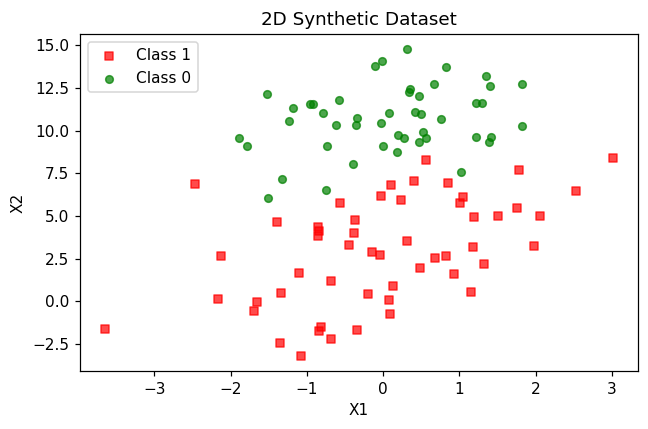

In [4]:
def load_2d_dataset(filepath="testSet.txt"):
    """Load 2D binary dataset.  Format: x1  x2  label (space-separated).
    Prepends a bias column of 1.0.
    """
    data_matrix, labels = [], []
    with open(filepath) as fh:
        for line in fh.readlines():
            parts = line.strip().split()
            data_matrix.append([1.0, float(parts[0]), float(parts[1])])
            labels.append(int(parts[2]))
    return np.array(data_matrix), np.array(labels)


def standardize_2d(X):
    """Standardize feature columns (skip bias at index 0)."""
    arr = X.copy().astype(float)
    means = arr[:, 1:].mean(axis=0)
    stds  = arr[:, 1:].std(axis=0)
    stds[stds == 0] = 1.0
    arr[:, 1:] = (arr[:, 1:] - means) / stds
    return arr, means, stds


X_2d, y_2d = load_2d_dataset("testSet.txt")
X_2d_std, _, _ = standardize_2d(X_2d)

print(f"Dataset shape : {X_2d.shape}")
print(f"Class balance : {(y_2d==0).sum()} class-0  /  {(y_2d==1).sum()} class-1")

# Scatter plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(X_2d[y_2d==1, 1], X_2d[y_2d==1, 2], s=25, c='red',   marker='s', alpha=0.7, label='Class 1')
ax.scatter(X_2d[y_2d==0, 1], X_2d[y_2d==0, 2], s=25, c='green',             alpha=0.7, label='Class 0')
ax.set_title('2D Synthetic Dataset'); ax.set_xlabel('X1'); ax.set_ylabel('X2'); ax.legend()
plt.tight_layout(); plt.show()

### 2.2 Batch gradient ascent with L2 regularization

Maximises the regularized log-likelihood:

$$\mathcal{L}(\mathbf{w}) = \sum_i \left[ y_i \log h_i + (1-y_i) \log(1-h_i) \right] - \frac{\lambda}{2} \|\mathbf{w}\|^2$$

In [5]:
def batch_gradient_ascent(X, y, learning_rate=0.005, max_iter=1000, l2_lambda=0.01):
    """Batch gradient ascent with optional L2 regularization.

    Parameters
    ----------
    X           : array (m, n) — includes bias column
    y           : array (m,)
    learning_rate : float
    max_iter    : int
    l2_lambda   : float — L2 penalty strength (0 = disabled)

    Returns
    -------
    weights      : ndarray (n,)
    loss_history : list[float]
    """
    X = np.array(X, dtype=float)    # (m, n)
    y = np.array(y, dtype=float)    # (m,)
    m, n = X.shape
    w = np.ones(n)
    loss_history = []

    for _ in range(max_iter):
        h = sigmoid(X @ w)                    # predicted probabilities (m,)
        error = y - h                         # residual
        penalty = np.zeros(n)
        penalty[1:] = l2_lambda * w[1:]       # do not penalize bias
        w = w + learning_rate * (X.T @ error - penalty)
        loss_history.append(log_loss(y, sigmoid(X @ w)))

    return w, loss_history


weights_batch, loss_hist_batch = batch_gradient_ascent(
    X_2d_std, y_2d, learning_rate=0.005, max_iter=1000, l2_lambda=0.01
)
print(f"Final weights: {weights_batch}")

Final weights: [ 1.26498317  1.18765554 -7.32628286]


### 2.3 Convergence curve

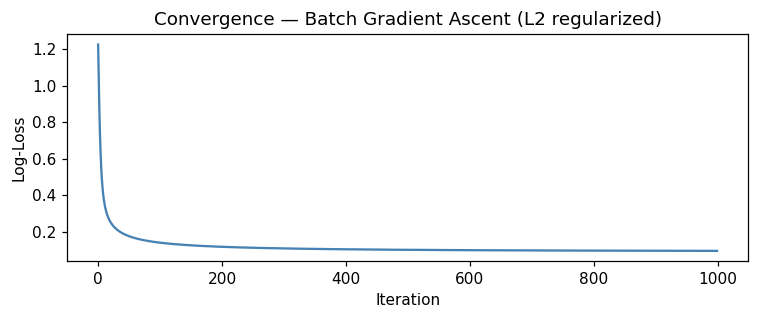

In [6]:
plt.figure(figsize=(7, 3))
plt.plot(loss_hist_batch, color='steelblue', lw=1.5)
plt.xlabel('Iteration'); plt.ylabel('Log-Loss')
plt.title('Convergence — Batch Gradient Ascent (L2 regularized)')
plt.tight_layout(); plt.show()

### 2.4 Evaluation + decision boundary

In [7]:
y_prob_batch = sigmoid(X_2d_std @ weights_batch)
y_pred_batch = (y_prob_batch >= 0.5).astype(int)

metrics_batch = evaluate(y_2d, y_pred_batch, y_prob_batch,
                         model_name="Logistic Regression — Batch GD (2D)")


  Evaluation — Logistic Regression — Batch GD (2D)

Confusion Matrix:
              Predicted 0   Predicted 1
  Actual 0           44             3
  Actual 1            2            51

Core Metrics:
  Accuracy    : 0.9500  (5.00% error rate)
  Precision   : 0.9444  (TP / (TP+FP))
  Recall      : 0.9623  (sensitivity, TP / (TP+FN))
  Specificity : 0.9362  (TN / (TN+FP))
  F1-Score    : 0.9533

Advanced Metrics:
  AUC-ROC     : 0.9964
  Log-Loss    : 0.0963
  MCC         : 0.8997  (ranges -1 to +1, 0 = random)

Full Classification Report:
              precision    recall  f1-score   support

     Class 0       0.96      0.94      0.95        47
     Class 1       0.94      0.96      0.95        53

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100



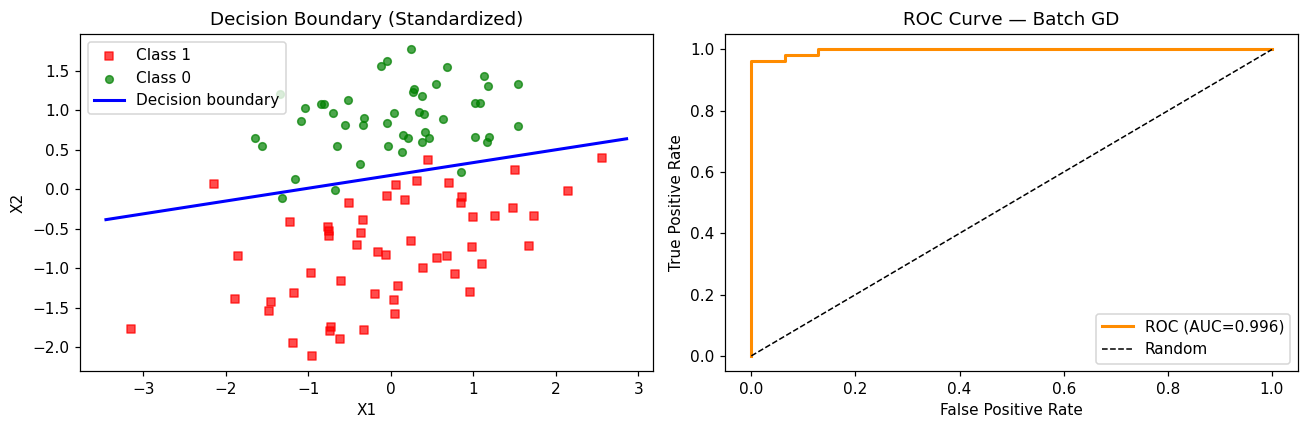

In [8]:
# Decision boundary: w0 + w1*x1 + w2*x2 = 0  =>  x2 = -(w0 + w1*x1) / w2
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left: decision boundary
ax = axes[0]
ax.scatter(X_2d_std[y_2d==1, 1], X_2d_std[y_2d==1, 2], s=25, c='red',   marker='s', alpha=0.7, label='Class 1')
ax.scatter(X_2d_std[y_2d==0, 1], X_2d_std[y_2d==0, 2], s=25, c='green',             alpha=0.7, label='Class 0')
x1r = np.linspace(X_2d_std[:, 1].min()-0.3, X_2d_std[:, 1].max()+0.3, 200)
x2b = -(weights_batch[0] + weights_batch[1] * x1r) / weights_batch[2]
ax.plot(x1r, x2b, 'b-', lw=2, label='Decision boundary')
ax.set_title('Decision Boundary (Standardized)'); ax.set_xlabel('X1'); ax.set_ylabel('X2'); ax.legend()

# Right: ROC curve
fpr, tpr, _ = roc_curve(y_2d, y_prob_batch)
auc_val = roc_auc_score(y_2d, y_prob_batch)
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC={auc_val:.3f})')
axes[1].plot([0,1],[0,1],'k--', lw=1, label='Random')
axes[1].set_xlabel('False Positive Rate'); axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve — Batch GD'); axes[1].legend(loc='lower right')

plt.tight_layout(); plt.show()

---
## Part 3 — Horse Colic Survival Prediction (UCI Dataset)

Binary classification on 21 clinical veterinary features.  
**Label:** 0 = did not survive, 1 = survived.

### 3.1 Load data

In [9]:
# Feature names translated from original UCI documentation
FEATURE_NAMES = [
    "surgery",                   # 1=yes, 2=no
    "age",                       # 1=adult, 2=young
    "rectal_temp",               # degrees Celsius
    "pulse",                     # beats per minute
    "respiratory_rate",          # breaths per minute
    "temp_extremities",          # 1=normal, 2=warm, 3=cool, 4=cold
    "peripheral_pulse",          # 1=normal, 2=increased, 3=reduced, 4=absent
    "mucous_membranes",          # 1-6 scale
    "capillary_refill",          # 1=<3sec, 2=>=3sec
    "pain",                      # 1=none … 5=extreme
    "peristalsis",               # 1=hypermotile … 4=absent
    "abdominal_distension",      # 1=none … 4=severe
    "nasogastric_tube",          # 1=none, 2=slight, 3=significant
    "nasogastric_reflux",        # 1=none, 2=>1L, 3=<1L
    "nasogastric_reflux_ph",
    "rectal_exam_feces",         # 1=normal … 4=increased
    "abdomen",                   # 1=normal … 5=distended_large
    "packed_cell_volume",
    "total_protein",
    "abdomcentesis_appearance",  # 1=clear, 2=cloudy, 3=serosanguinous
    "abdomcentesis_total_protein",
]


def load_colic_data(filepath):
    """Load tab-separated horse colic data."""
    X, y = [], []
    with open(filepath) as fh:
        for line in fh.readlines():
            parts = line.strip().split("\t")
            X.append([float(v) for v in parts[:-1]])
            y.append(float(parts[-1]))
    return np.array(X), np.array(y)


X_train, y_train = load_colic_data("horseColicTraining.txt")
X_test,  y_test  = load_colic_data("horseColicTest.txt")

print(f"Training : {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test     : {X_test.shape[0]} samples")
print(f"Survival rate — train: {y_train.mean()*100:.1f}%  test: {y_test.mean()*100:.1f}%")

Training : 299 samples, 21 features
Test     : 67 samples
Survival rate — train: 59.5%  test: 70.1%


### 3.2 Correlation matrix — selecting interaction terms

The correlation matrix identifies which feature pairs have the strongest linear relationships.  
These pairs are the best candidates for interaction terms ($x_i \times x_j$), which allow the model to capture joint effects.

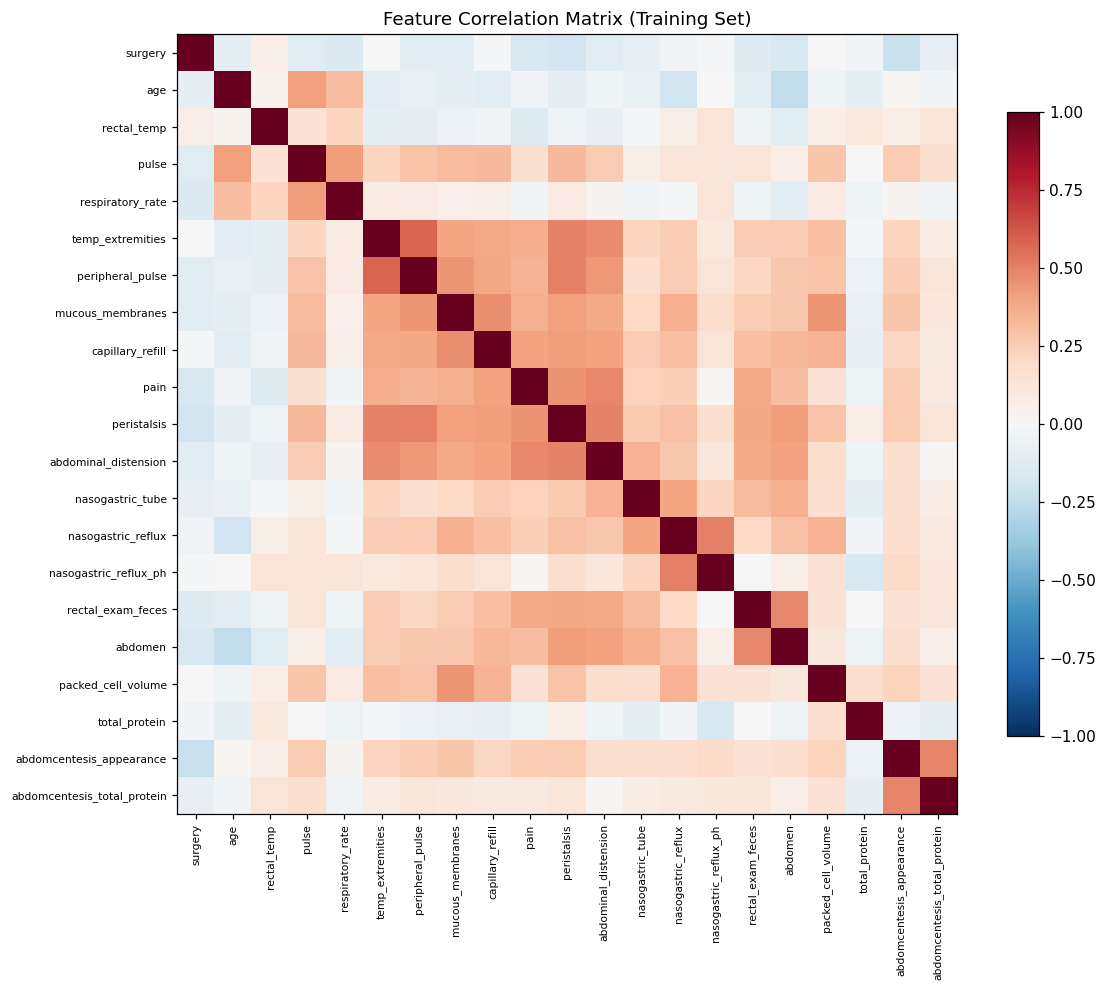


Top 5 correlated pairs (interaction term candidates):
  Feature A                  Feature B                         r
  temp_extremities           peripheral_pulse             0.5807
  nasogastric_reflux         nasogastric_reflux_ph        0.5073
  peripheral_pulse           peristalsis                  0.5038
  peristalsis                abdominal_distension         0.4998
  temp_extremities           peristalsis                  0.4952


In [10]:
def plot_correlation_matrix(X, names, title="Feature Correlation Matrix"):
    """Display correlation heatmap."""
    corr = np.corrcoef(X.T)
    fig, ax = plt.subplots(figsize=(11, 9))
    im = ax.imshow(corr, cmap="RdBu_r", vmin=-1, vmax=1)
    plt.colorbar(im, ax=ax, shrink=0.8)
    ax.set_xticks(range(len(names))); ax.set_xticklabels(names, rotation=90, fontsize=7)
    ax.set_yticks(range(len(names))); ax.set_yticklabels(names, fontsize=7)
    ax.set_title(title, fontsize=12)
    plt.tight_layout(); plt.show()
    return corr


def top_correlated_pairs(X, names, top_n=5):
    """Return the top-N most correlated (by |r|) feature pairs."""
    corr = np.corrcoef(X.T)
    pairs = [(i, j, corr[i, j])
             for i in range(corr.shape[0])
             for j in range(i+1, corr.shape[0])]
    pairs.sort(key=lambda t: abs(t[2]), reverse=True)
    print(f"\nTop {top_n} correlated pairs (interaction term candidates):")
    print(f"  {'Feature A':<26} {'Feature B':<26} {'r':>8}")
    for i, j, r in pairs[:top_n]:
        print(f"  {names[i]:<26} {names[j]:<26} {r:>8.4f}")
    return pairs[:top_n]


corr_matrix = plot_correlation_matrix(X_train, FEATURE_NAMES,
                                       "Feature Correlation Matrix (Training Set)")
top_pairs = top_correlated_pairs(X_train, FEATURE_NAMES, top_n=5)

### 3.3 Add interaction terms

In [11]:
def add_interaction_terms(X, pairs):
    """Append x_i * x_j columns for each (i, j) pair."""
    cols = [X[:, i] * X[:, j] for i, j, *_ in pairs]
    return np.hstack([X] + [c.reshape(-1, 1) for c in cols])


# Use top-3 most correlated pairs as interaction terms
interaction_pairs = [(i, j) for i, j, _ in top_pairs[:3]]
interaction_labels = [(FEATURE_NAMES[i], FEATURE_NAMES[j]) for i, j in interaction_pairs]

X_train_aug = add_interaction_terms(X_train, interaction_pairs)
X_test_aug  = add_interaction_terms(X_test,  interaction_pairs)

print(f"Interaction terms added: {interaction_labels}")
print(f"Feature count: {X_train.shape[1]} → {X_train_aug.shape[1]}")

Interaction terms added: [('temp_extremities', 'peripheral_pulse'), ('nasogastric_reflux', 'nasogastric_reflux_ph'), ('peripheral_pulse', 'peristalsis')]
Feature count: 21 → 24


### 3.4 Feature standardization (no data leakage)

In [12]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train_aug)   # fit only on training set
X_test_s  = scaler.transform(X_test_aug)        # apply same transform to test

print("Standardization complete.")
print(f"Train feature means (first 5): {X_train_s.mean(axis=0)[:5].round(6)}")
print(f"Train feature stds  (first 5): {X_train_s.std(axis=0)[:5].round(6)}")

Standardization complete.
Train feature means (first 5): [ 0.  0. -0. -0.  0.]
Train feature stds  (first 5): [1. 1. 1. 1. 1.]


---
## Part 4 — Model A: Custom Stochastic Gradient Ascent

Uses a **decaying learning rate** $\alpha = \frac{4}{1 + j + i} + 0.01$ to prevent oscillation near convergence.

In [13]:
def stochastic_gradient_ascent(X, y, num_iterations=500, seed=42):
    """Stochastic gradient ascent with decaying learning rate.

    At each iteration, all samples are visited exactly once in random order.
    Learning rate alpha = 4/(1+j+i) + 0.01 decreases over time.
    """
    random.seed(seed)
    m, n = X.shape
    weights = np.ones(n)
    loss_history = []

    for j in range(num_iterations):
        data_index = list(range(m))
        for i in range(m):
            alpha = 4.0 / (1.0 + j + i) + 0.01      # decaying learning rate
            rand_idx = int(random.uniform(0, len(data_index)))
            h = sigmoid(np.dot(X[data_index[rand_idx]], weights))
            error = y[data_index[rand_idx]] - h
            weights += alpha * error * X[data_index[rand_idx]]
            del data_index[rand_idx]

        # Record log-loss after each complete pass
        probs = sigmoid(X @ weights)
        loss_history.append(log_loss(y, probs))

    return weights, loss_history


print("Training custom stochastic gradient ascent (500 iterations)...")
weights_sgd, loss_hist_sgd = stochastic_gradient_ascent(X_train_s, y_train, num_iterations=500)
print("Done.")

Training custom stochastic gradient ascent (500 iterations)...


Done.


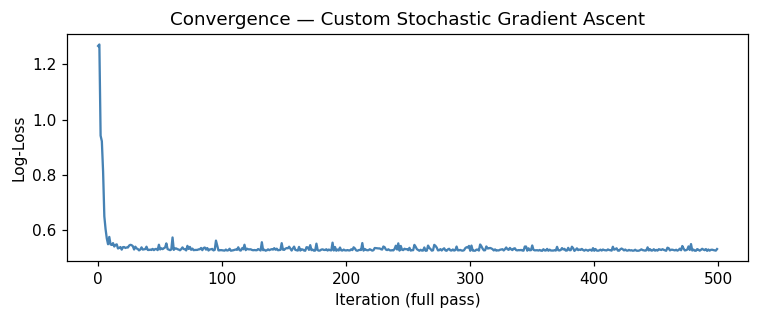

In [14]:
plt.figure(figsize=(7, 3))
plt.plot(loss_hist_sgd, color='steelblue', lw=1.5)
plt.xlabel('Iteration (full pass)'); plt.ylabel('Log-Loss')
plt.title('Convergence — Custom Stochastic Gradient Ascent')
plt.tight_layout(); plt.show()

In [15]:
y_pred_sgd = (sigmoid(X_test_s @ weights_sgd) >= 0.5).astype(float)
y_prob_sgd = sigmoid(X_test_s @ weights_sgd)

metrics_sgd = evaluate(y_test, y_pred_sgd, y_prob_sgd,
                       model_name="Custom Stochastic Gradient Ascent",
                       class_names=["Did Not Survive", "Survived"])


  Evaluation — Custom Stochastic Gradient Ascent

Confusion Matrix:
              Predicted 0   Predicted 1
  Actual 0           14             6
  Actual 1           11            36

Core Metrics:
  Accuracy    : 0.7463  (25.37% error rate)
  Precision   : 0.8571  (TP / (TP+FP))
  Recall      : 0.7660  (sensitivity, TP / (TP+FN))
  Specificity : 0.7000  (TN / (TN+FP))
  F1-Score    : 0.8090

Advanced Metrics:
  AUC-ROC     : 0.7947
  Log-Loss    : 0.6014
  MCC         : 0.4409  (ranges -1 to +1, 0 = random)

Full Classification Report:
                 precision    recall  f1-score   support

Did Not Survive       0.56      0.70      0.62        20
       Survived       0.86      0.77      0.81        47

       accuracy                           0.75        67
      macro avg       0.71      0.73      0.72        67
   weighted avg       0.77      0.75      0.75        67



---
## Part 5 — Model B: Sklearn LogisticRegression (L2, lbfgs)

Uses the L-BFGS second-order solver with L2 regularization as a benchmark.

In [16]:
clf = LogisticRegression(solver="lbfgs", max_iter=2000, C=1.0, random_state=42)
clf.fit(X_train_s, y_train)

y_pred_lr = clf.predict(X_test_s)
y_prob_lr = clf.predict_proba(X_test_s)[:, 1]

metrics_lr = evaluate(y_test, y_pred_lr, y_prob_lr,
                      model_name="Sklearn LogisticRegression (L2, lbfgs)",
                      class_names=["Did Not Survive", "Survived"])


  Evaluation — Sklearn LogisticRegression (L2, lbfgs)

Confusion Matrix:
              Predicted 0   Predicted 1
  Actual 0           13             7
  Actual 1            9            38

Core Metrics:
  Accuracy    : 0.7612  (23.88% error rate)
  Precision   : 0.8444  (TP / (TP+FP))
  Recall      : 0.8085  (sensitivity, TP / (TP+FN))
  Specificity : 0.6500  (TN / (TN+FP))
  F1-Score    : 0.8261

Advanced Metrics:
  AUC-ROC     : 0.7904
  Log-Loss    : 0.5548
  MCC         : 0.4468  (ranges -1 to +1, 0 = random)

Full Classification Report:
                 precision    recall  f1-score   support

Did Not Survive       0.59      0.65      0.62        20
       Survived       0.84      0.81      0.83        47

       accuracy                           0.76        67
      macro avg       0.72      0.73      0.72        67
   weighted avg       0.77      0.76      0.76        67



### 5.1 ROC curve comparison

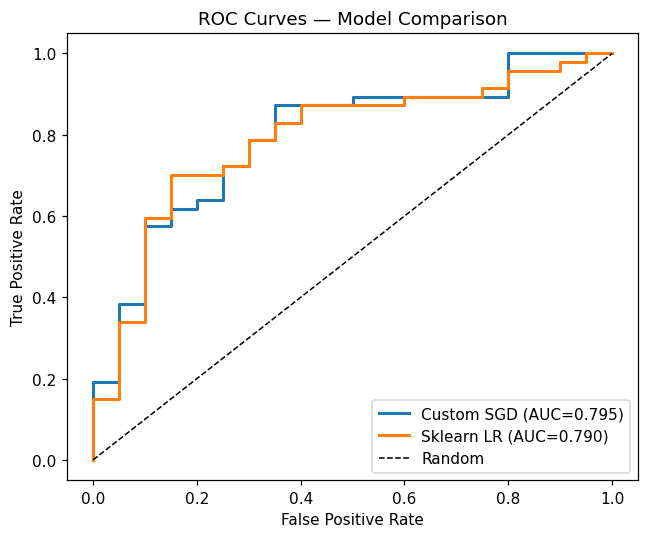

In [17]:
plt.figure(figsize=(6, 5))
for name, y_prob in [("Custom SGD", y_prob_sgd), ("Sklearn LR", y_prob_lr)]:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_val = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC={auc_val:.3f})")
plt.plot([0,1],[0,1],'k--', lw=1, label='Random')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curves — Model Comparison')
plt.legend(loc='lower right')
plt.tight_layout(); plt.show()

---
## Part 6 — Stratified K-Fold Cross-Validation

Provides a robust generalisation estimate by training and evaluating on 5 different data splits.  
Standardization is applied **within each fold** to prevent data leakage.

In [18]:
def stratified_kfold_cv(X, y, n_splits=5, C=1.0):
    """Stratified k-fold CV with per-fold standardization."""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_metrics = []

    for fold, (tr_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_tr, X_val = X[tr_idx], X[val_idx]
        y_tr, y_val = y[tr_idx], y[val_idx]

        # Fit scaler on fold-train only
        sc = StandardScaler()
        X_tr_s  = sc.fit_transform(X_tr)
        X_val_s = sc.transform(X_val)

        model = LogisticRegression(solver="lbfgs", max_iter=2000, C=C, random_state=42)
        model.fit(X_tr_s, y_tr)

        yp  = model.predict(X_val_s)
        ypr = model.predict_proba(X_val_s)[:, 1]

        fold_metrics.append({
            "accuracy" : (yp == y_val).mean(),
            "auc_roc"  : roc_auc_score(y_val, ypr),
            "log_loss" : log_loss(y_val, ypr),
            "f1"       : 2*((yp==1)&(y_val==1)).sum() / max((yp==1).sum()+(y_val==1).sum(), 1),
            "mcc"      : matthews_corrcoef(y_val, yp),
        })
        print(f"  Fold {fold}: acc={fold_metrics[-1]['accuracy']:.3f}  "
              f"auc={fold_metrics[-1]['auc_roc']:.3f}  "
              f"ll={fold_metrics[-1]['log_loss']:.3f}")

    print(f"\n{'='*50}")
    print(f"  {n_splits}-Fold CV Summary (mean ± std)")
    print(f"{'='*50}")
    for key in fold_metrics[0]:
        vals = [m[key] for m in fold_metrics]
        print(f"  {key:<12}: {np.mean(vals):.4f} ± {np.std(vals):.4f}")
    return fold_metrics


# Combine train+test for full CV
X_full = np.vstack([X_train_aug, X_test_aug])
y_full = np.concatenate([y_train, y_test])

print("Running 5-fold CV on full dataset (augmented with interaction terms)...\n")
cv_results = stratified_kfold_cv(X_full, y_full, n_splits=5)

Running 5-fold CV on full dataset (augmented with interaction terms)...



  Fold 1: acc=0.757  auc=0.797  ll=0.540
  Fold 2: acc=0.740  auc=0.810  ll=0.514
  Fold 3: acc=0.671  auc=0.717  ll=0.657
  Fold 4: acc=0.616  auc=0.704  ll=0.651


  Fold 5: acc=0.753  auc=0.748  ll=0.562

  5-Fold CV Summary (mean ± std)
  accuracy    : 0.7075 ± 0.0551
  auc_roc     : 0.7549 ± 0.0420
  log_loss    : 0.5849 ± 0.0587
  f1          : 0.7762 ± 0.0421
  mcc         : 0.3661 ± 0.1278


---
## Part 7 — Summary Comparison Table

In [19]:
print(f"\n{'='*60}")
print("  Final Test-Set Comparison")
print(f"{'='*60}")
print(f"  {'Metric':<14} {'Custom SGD':>14} {'Sklearn LR':>14}")
print(f"  {'-'*44}")
for key in ["accuracy", "precision", "recall", "specificity",
            "f1", "auc_roc", "log_loss", "mcc"]:
    print(f"  {key:<14} {metrics_sgd[key]:>14.4f} {metrics_lr[key]:>14.4f}")

print(f"\n  Note: error rate = 1 - accuracy")
print(f"  Custom SGD error rate : {(1-metrics_sgd['accuracy'])*100:.2f}%")
print(f"  Sklearn LR error rate : {(1-metrics_lr['accuracy'])*100:.2f}%")


  Final Test-Set Comparison
  Metric             Custom SGD     Sklearn LR
  --------------------------------------------
  accuracy               0.7463         0.7612
  precision              0.8571         0.8444
  recall                 0.7660         0.8085
  specificity            0.7000         0.6500
  f1                     0.8090         0.8261
  auc_roc                0.7947         0.7904
  log_loss               0.6014         0.5548
  mcc                    0.4409         0.4468

  Note: error rate = 1 - accuracy
  Custom SGD error rate : 25.37%
  Sklearn LR error rate : 23.88%


---
# Part 8 — Improving Model Performance: Advanced Methodologies

This section systematically applies six techniques to push accuracy beyond the baseline results above. Each method targets a specific weakness in the standard logistic regression pipeline.

| Method | What it addresses |
|---|---|
| 8.1 Regularization tuning (L1 / L2 / ElasticNet) | Overfitting, feature sparsity |
| 8.2 Feature selection (univariate + L1-based) | Irrelevant/noisy features |
| 8.3 Threshold optimization | Sub-optimal decision boundary at 0.5 |
| 8.4 Polynomial feature expansion | Non-linear decision boundaries |
| 8.5 Learning curves | Diagnosing bias vs. variance |
| 8.6 Final leaderboard | Side-by-side comparison of all approaches |

## 8.1 Regularization Tuning — L1, L2, and ElasticNet

**Why it helps:** The default `C=1.0` may not be optimal. L1 regularization also induces sparsity (zeroing out weak features), while ElasticNet blends both penalties.

We sweep `C` over a log-scale grid and compare all three penalties using cross-validated AUC-ROC.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

# Log-scale grid of regularization strengths
C_values = np.logspace(-3, 3, 13)

# Re-use the augmented (interaction terms) full dataset
# Standardization is handled inside each CV fold via Pipeline
results_reg = {}

for penalty, solver in [("l1", "liblinear"), ("l2", "lbfgs"), ("elasticnet", "saga")]:
    scores = []
    for C in C_values:
        kwargs = dict(penalty=penalty, C=C, solver=solver,
                      max_iter=3000, random_state=42)
        if penalty == "elasticnet":
            kwargs["l1_ratio"] = 0.5   # equal blend of L1 and L2
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(**kwargs))
        ])
        cv_auc = cross_val_score(pipe, X_full, y_full,
                                  cv=StratifiedKFold(5, shuffle=True, random_state=42),
                                  scoring="roc_auc").mean()
        scores.append(cv_auc)
    results_reg[penalty] = scores
    best_C = C_values[np.argmax(scores)]
    print(f"  {penalty:<12} best C={best_C:.4f}  AUC={max(scores):.4f}")

# Plot
plt.figure(figsize=(8, 4))
for penalty, scores in results_reg.items():
    plt.plot(np.log10(C_values), scores, marker='o', markersize=4, label=penalty)
plt.xlabel("log₁₀(C)  — smaller = stronger regularization")
plt.ylabel("CV AUC-ROC")
plt.title("Regularization Strength vs. AUC-ROC")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# Store best config
best_penalty = max(results_reg, key=lambda p: max(results_reg[p]))
best_C_val   = C_values[np.argmax(results_reg[best_penalty])]
print(f"\nBest config: penalty={best_penalty}, C={best_C_val:.4f}, AUC={max(results_reg[best_penalty]):.4f}")

## 8.2 Feature Selection

**Why it helps:** With 21 original features + 3 interaction terms = 24 dimensions, some features may add noise rather than signal. Removing them reduces overfitting.

Two approaches are compared:
- **Univariate (ANOVA F-test):** ranks each feature independently by its correlation with the label
- **L1-based (SelectFromModel):** uses the sparsity of L1 regularization to zero out weak weights

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel

aug_feature_names = FEATURE_NAMES + [
    f"{FEATURE_NAMES[i]}×{FEATURE_NAMES[j]}" for i, j in interaction_pairs
]

# ── Univariate F-test ranking ─────────────────────────────────────────────────
selector_uni = SelectKBest(f_classif, k="all")
selector_uni.fit(X_train_s, y_train)
f_scores = selector_uni.scores_

ranked_idx = np.argsort(f_scores)[::-1]
print("Feature ranking by ANOVA F-score:")
for rank, idx in enumerate(ranked_idx, 1):
    print(f"  {rank:2d}. {aug_feature_names[idx]:<35} F={f_scores[idx]:.2f}")

# Bar chart
plt.figure(figsize=(10, 4))
plt.bar(range(len(f_scores)), f_scores[ranked_idx], color="steelblue", alpha=0.8)
plt.xticks(range(len(f_scores)),
           [aug_feature_names[i] for i in ranked_idx], rotation=90, fontsize=7)
plt.ylabel("ANOVA F-score")
plt.title("Feature Importance — Univariate F-test")
plt.tight_layout(); plt.show()

# ── L1-based selection ────────────────────────────────────────────────────────
l1_clf = LogisticRegression(penalty="l1", solver="liblinear",
                             C=best_C_val, max_iter=3000, random_state=42)
l1_clf.fit(X_train_s, y_train)

selector_l1 = SelectFromModel(l1_clf, prefit=True)
selected_mask = selector_l1.get_support()
selected_names = [aug_feature_names[i] for i, s in enumerate(selected_mask) if s]
print(f"\nL1 selected {selected_mask.sum()} / {len(selected_mask)} features:")
for name in selected_names:
    print(f"  • {name}")

In [ ]:
# Train final model on L1-selected features and evaluate
X_train_sel = selector_l1.transform(X_train_s)
X_test_sel  = selector_l1.transform(X_test_s)

clf_sel = LogisticRegression(penalty="l2", solver="lbfgs",
                              C=best_C_val, max_iter=3000, random_state=42)
clf_sel.fit(X_train_sel, y_train)

y_pred_sel = clf_sel.predict(X_test_sel)
y_prob_sel = clf_sel.predict_proba(X_test_sel)[:, 1]
metrics_sel = evaluate(y_test, y_pred_sel, y_prob_sel,
                       model_name=f"L1 Feature Selection ({selected_mask.sum()} features)",
                       class_names=["Did Not Survive", "Survived"])

## 8.3 Threshold Optimization

**Why it helps:** The default threshold of 0.5 is arbitrary. For clinical data where missing a sick horse (false negative) is worse than a false alarm, we may want to lower the threshold to improve recall at the cost of some precision.

We find the threshold that maximises F1, and also plot the full precision-recall tradeoff.

In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score

# Use the best sklearn model probabilities from Part 5
thresholds = np.arange(0.10, 0.91, 0.01)
f1_scores  = [f1_score(y_test, (y_prob_lr >= t).astype(int)) for t in thresholds]
acc_scores = [(y_test == (y_prob_lr >= t).astype(int)).mean() for t in thresholds]

best_thresh_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_thresh_idx]
print(f"Optimal threshold (max F1): {best_thresh:.2f}")
print(f"  F1 at 0.50 : {f1_score(y_test, (y_prob_lr >= 0.50).astype(int)):.4f}")
print(f"  F1 at {best_thresh:.2f} : {f1_scores[best_thresh_idx]:.4f}")

# Plot threshold vs F1 and accuracy
fig, ax1 = plt.subplots(figsize=(8, 4))
ax1.plot(thresholds, f1_scores, color="darkorange", lw=2, label="F1-score")
ax1.plot(thresholds, acc_scores, color="steelblue", lw=2, label="Accuracy")
ax1.axvline(best_thresh, color="red", linestyle="--", alpha=0.7,
            label=f"Optimal threshold ({best_thresh:.2f})")
ax1.axvline(0.5, color="gray", linestyle=":", alpha=0.7, label="Default (0.50)")
ax1.set_xlabel("Classification Threshold"); ax1.set_ylabel("Score")
ax1.set_title("Threshold vs. F1 and Accuracy"); ax1.legend(); ax1.grid(alpha=0.3)
plt.tight_layout(); plt.show()

# Precision-Recall curve
precision, recall, pr_thresh = precision_recall_curve(y_test, y_prob_lr)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, color="purple", lw=2)
plt.scatter(recall[np.argmin(np.abs(pr_thresh - best_thresh))],
            precision[np.argmin(np.abs(pr_thresh - best_thresh))],
            color="red", zorder=5, s=80, label=f"Optimal threshold ({best_thresh:.2f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curve"); plt.legend(); plt.grid(alpha=0.3)
plt.tight_layout(); plt.show()

# Evaluate at optimal threshold
y_pred_opt = (y_prob_lr >= best_thresh).astype(int)
metrics_opt = evaluate(y_test, y_pred_opt, y_prob_lr,
                       model_name=f"Sklearn LR — Optimized Threshold ({best_thresh:.2f})",
                       class_names=["Did Not Survive", "Survived"])

## 8.4 Polynomial Feature Expansion

**Why it helps:** Logistic regression is inherently linear. Adding degree-2 polynomial features (squares and all pairwise products) allows the model to learn curved decision boundaries without switching algorithms.

We compare a tuned degree-2 polynomial model against the baseline.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# Build pipeline: standardize → polynomial expansion → L2 logistic regression
poly_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("poly",   PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)),
    ("clf",    LogisticRegression(penalty="l2", solver="lbfgs",
                                   C=best_C_val, max_iter=3000, random_state=42))
])

poly_pipe.fit(X_train_aug, y_train)

n_poly_features = poly_pipe.named_steps["poly"].n_output_features_
print(f"Original features  : {X_train_aug.shape[1]}")
print(f"After degree-2 poly: {n_poly_features} features")

y_pred_poly = poly_pipe.predict(X_test_aug)
y_prob_poly = poly_pipe.predict_proba(X_test_aug)[:, 1]
metrics_poly = evaluate(y_test, y_pred_poly, y_prob_poly,
                        model_name=f"Polynomial (degree=2) + L2 Logistic",
                        class_names=["Did Not Survive", "Survived"])

# CV check to make sure we're not overfitting
cv_poly = cross_val_score(poly_pipe, X_full, y_full,
                           cv=StratifiedKFold(5, shuffle=True, random_state=42),
                           scoring="roc_auc")
print(f"\nPolynomial model — 5-fold CV AUC: {cv_poly.mean():.4f} ± {cv_poly.std():.4f}")

## 8.5 Learning Curves

**Why it helps:** Learning curves reveal whether the model is suffering from **high bias** (underfitting — needs more complexity) or **high variance** (overfitting — needs more data or regularization). This guides which of the above techniques to prioritize.

In [ ]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, title, cv=5, n_jobs=-1):
    """Plot training and cross-validation score as training size grows."""
    train_sizes = np.linspace(0.15, 1.0, 12)
    train_sz, train_scores, val_scores = learning_curve(
        estimator, X, y,
        train_sizes=train_sizes,
        cv=StratifiedKFold(cv, shuffle=True, random_state=42),
        scoring="roc_auc",
        n_jobs=n_jobs
    )

    train_mean = train_scores.mean(axis=1)
    train_std  = train_scores.std(axis=1)
    val_mean   = val_scores.mean(axis=1)
    val_std    = val_scores.std(axis=1)

    plt.figure(figsize=(7, 4))
    plt.plot(train_sz, train_mean, "o-", color="darkorange", lw=2, label="Training AUC")
    plt.fill_between(train_sz, train_mean - train_std, train_mean + train_std,
                     alpha=0.15, color="darkorange")
    plt.plot(train_sz, val_mean, "o-", color="steelblue", lw=2, label="CV AUC")
    plt.fill_between(train_sz, val_mean - val_std, val_mean + val_std,
                     alpha=0.15, color="steelblue")
    plt.xlabel("Training set size"); plt.ylabel("AUC-ROC")
    plt.title(f"Learning Curve — {title}")
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

    gap = train_mean[-1] - val_mean[-1]
    if gap > 0.10:
        diagnosis = "HIGH VARIANCE (overfitting) — consider more regularization or more data"
    elif val_mean[-1] < 0.75:
        diagnosis = "HIGH BIAS (underfitting) — consider more features or polynomial expansion"
    else:
        diagnosis = "GOOD FIT — train/val AUC are close and both high"
    print(f"  Train AUC: {train_mean[-1]:.4f}  |  CV AUC: {val_mean[-1]:.4f}  |  Gap: {gap:.4f}")
    print(f"  Diagnosis: {diagnosis}")


baseline_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(penalty="l2", solver="lbfgs",
                                C=1.0, max_iter=2000, random_state=42))
])

tuned_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(penalty=best_penalty, solver="lbfgs" if best_penalty == "l2" else "liblinear",
                                C=best_C_val, max_iter=3000, random_state=42))
])

print("=== Baseline (C=1.0, L2) ===")
plot_learning_curve(baseline_pipe, X_full, y_full, "Baseline L2 Logistic")

print("=== Tuned (best penalty & C) ===")
plot_learning_curve(tuned_pipe, X_full, y_full, f"Tuned ({best_penalty}, C={best_C_val:.3f})")

## 8.6 Final Leaderboard

All models ranked by test-set AUC-ROC, with a full metric breakdown.

In [ ]:
all_models = {
    "Custom SGD (baseline)"         : metrics_sgd,
    "Sklearn LR — default"          : metrics_lr,
    f"L1 Feature Selection"         : metrics_sel,
    f"Optimized Threshold ({best_thresh:.2f})": metrics_opt,
    "Polynomial degree-2"           : metrics_poly,
}

# Sort by AUC-ROC descending
sorted_models = sorted(all_models.items(), key=lambda x: x[1]["auc_roc"], reverse=True)

print(f"\n{'='*72}")
print("  FINAL LEADERBOARD — sorted by AUC-ROC")
print(f"{'='*72}")
header = f"  {'Model':<38} {'AUC':>6} {'Acc':>6} {'F1':>6} {'MCC':>6} {'LogLoss':>9}"
print(header)
print(f"  {'-'*68}")
for name, m in sorted_models:
    print(f"  {name:<38} {m['auc_roc']:>6.4f} {m['accuracy']:>6.4f} "
          f"{m['f1']:>6.4f} {m['mcc']:>6.4f} {m['log_loss']:>9.4f}")

# Bar chart of AUC-ROC
names  = [n for n, _ in sorted_models]
aucs   = [m["auc_roc"] for _, m in sorted_models]
colors = ["#2ecc71" if i == 0 else "#3498db" for i in range(len(names))]

plt.figure(figsize=(9, 4))
bars = plt.barh(range(len(names)), aucs, color=colors, alpha=0.85)
plt.yticks(range(len(names)), names, fontsize=9)
plt.xlabel("AUC-ROC"); plt.title("Model Comparison — AUC-ROC")
plt.xlim(0.5, 1.0); plt.grid(axis="x", alpha=0.3)
for bar, val in zip(bars, aucs):
    plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
             f"{val:.4f}", va="center", fontsize=8)
plt.tight_layout(); plt.show()

# Overlay all ROC curves
plt.figure(figsize=(7, 5))
roc_data = [
    ("Custom SGD",              y_prob_sgd),
    ("Sklearn LR default",      y_prob_lr),
    ("L1 Feature Selection",    y_prob_sel),
    ("Optimized Threshold",     y_prob_lr),   # same probs, different threshold
    ("Polynomial degree-2",     y_prob_poly),
]
for name, yp in roc_data:
    fpr, tpr, _ = roc_curve(y_test, yp)
    auc_v = roc_auc_score(y_test, yp)
    plt.plot(fpr, tpr, lw=1.8, label=f"{name} ({auc_v:.3f})")
plt.plot([0,1],[0,1],"k--", lw=1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves — All Models"); plt.legend(fontsize=8, loc="lower right")
plt.tight_layout(); plt.show()